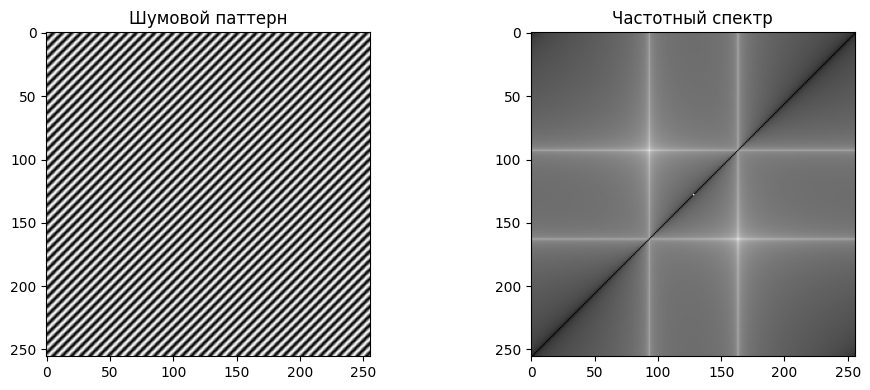

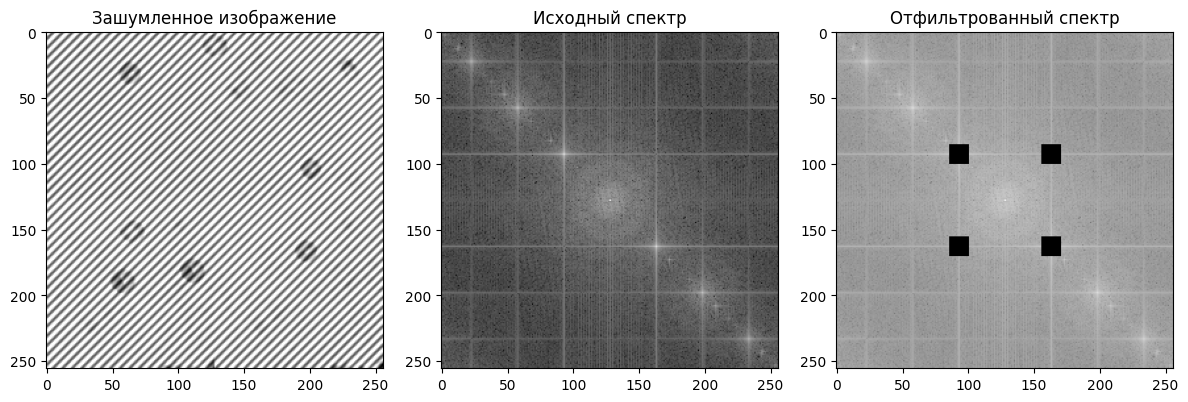

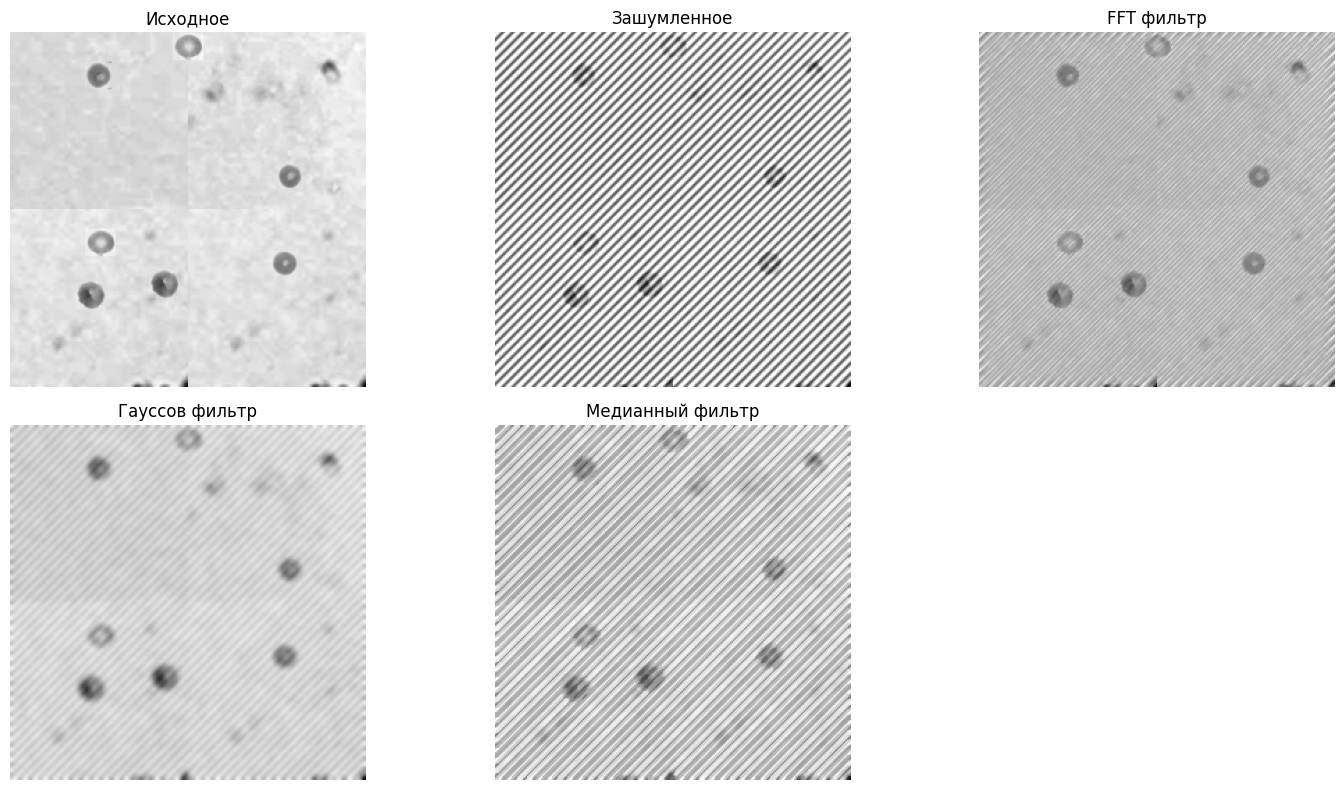

In [ ]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity

def load_tiles(directory):
    tiles = []
    for file in os.listdir(directory):
        if file.lower().endswith((".png", ".jpg")):
            img = cv2.imread(os.path.join(directory, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                tiles.append(img)
    return tiles

def create_texture(base_tiles, num_components=10, canvas_size=(256, 256)):
    selected = random.choices(base_tiles, k=num_components)
    canvas = np.zeros(canvas_size, dtype=np.uint8)
    tile_size = 128
    
    for i in range(0, canvas_size[0], tile_size):
        for j in range(0, canvas_size[1], tile_size):
            if selected:
                tile = selected.pop()
                if tile.shape != (tile_size, tile_size):
                    tile = cv2.resize(tile, (tile_size, tile_size))
                try:
                    canvas[i:i+tile_size, j:j+tile_size] = tile
                except:
                    continue
    return canvas

def add_objects(base_texture, objects, count=7):
    result = base_texture.copy()
    h, w = base_texture.shape
    
    for _ in range(count):
        obj = random.choice(objects)
        obj = cv2.resize(obj, (obj.shape[1]//3, obj.shape[0]//3))
        
        y = random.randint(0, h - obj.shape[0])
        x = random.randint(0, w - obj.shape[1])
        
        mask = np.zeros_like(obj, dtype=np.float32)
        cv2.ellipse(mask, (obj.shape[1]//2, obj.shape[0]//2), 
                    (obj.shape[1]//3, obj.shape[0]//4), 0, 0, 360, 1, -1)
        mask = cv2.GaussianBlur(mask, (35, 35), 0)
        
        region = result[y:y+obj.shape[0], x:x+obj.shape[1]]
        result[y:y+obj.shape[0], x:x+obj.shape[1]] = (region*(1-mask) + obj*mask).astype(np.uint8)
    
    return result

def apply_corrupting_noise(image, frequency=25, intensity=0.4):
    rows, cols = image.shape
    x = np.linspace(0, 2*np.pi, cols)
    y = np.linspace(0, 2*np.pi, rows)
    X, Y = np.meshgrid(x, y)
    
    pattern = 1 + intensity*np.sin(frequency*X + frequency*Y)
    noisy = np.clip(image.astype(float)*pattern, 0, 255).astype(np.uint8)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(pattern, cmap='gray')
    plt.title('Шумовой паттерн')

    fft_spectrum = 20*np.log(np.abs(np.fft.fftshift(np.fft.fft2(pattern))) + 1e-5)
    plt.subplot(122)
    plt.imshow(fft_spectrum, cmap='gray')
    plt.title('Частотный спектр')
    
    plt.tight_layout()
    plt.show()
    
    return noisy

def clean_with_fft(noisy_img, freq=25, filter_size=7):
    f = np.fft.fft2(noisy_img)
    fshift = np.fft.fftshift(f)
    
    h, w = noisy_img.shape
    cy, cx = h//2, w//2
    mask = np.ones((h, w), dtype=np.float32)
    
    for dx, dy in [(freq, freq), (-freq, -freq), 
                  (freq, -freq), (-freq, freq)]:
        x_start = cx + dx - filter_size
        y_start = cy + dy - filter_size
        x_end = cx + dx + filter_size
        y_end = cy + dy + filter_size
        
        if 0 <= x_start < w and 0 <= y_start < h:
            cv2.rectangle(mask, (x_start, y_start),
                         (x_end, y_end), 0, -1)

    filtered_spectrum = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(filtered_spectrum))
    restored = np.abs(img_back)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(131)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Зашумленное изображение')
    
    plt.subplot(132)
    plt.imshow(20*np.log(np.abs(fshift) + 1e-5), cmap='gray')
    plt.title('Исходный спектр')
    
    plt.subplot(133)
    plt.imshow(20*np.log(np.abs(filtered_spectrum) + 1e-5), cmap='gray')
    plt.title('Отфильтрованный спектр')
    
    plt.tight_layout()
    plt.show()

    return np.clip(restored, 0, 255).astype(np.uint8)

def evaluate_performance(clean, processed):
    return (mean_squared_error(clean, processed),
            structural_similarity(clean, processed, data_range=255))

tiles_dir = os.path.join('content', 'patches')
texture_tiles = load_tiles(os.path.join(tiles_dir, 'background'))
cell_tiles = load_tiles(os.path.join(tiles_dir, 'cells'))

texture = create_texture(texture_tiles)
sample_image = add_objects(texture, cell_tiles)

corrupted = apply_corrupting_noise(sample_image, frequency=35, intensity=0.35)

fft_restored = clean_with_fft(corrupted, freq=35)

gaussian_blur = cv2.GaussianBlur(corrupted, (9,9), 2)
median_filter = cv2.medianBlur(corrupted, 5)

results = {
    'Исходное': sample_image,
    'Зашумленное': corrupted,
    'FFT фильтр': fft_restored,
    'Гауссов фильтр': gaussian_blur,
    'Медианный фильтр': median_filter
}

plt.figure(figsize=(15, 8))
for i, (title, img) in enumerate(results.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    if title != 'Исходное':
        mse, ssim = evaluate_performance(sample_image, img)
        plt.xlabel(f'MSE: {mse:.1f}\nSSIM: {ssim:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()